In [23]:
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import pickle

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

In [24]:
import params
import make_dictionaries

source_directory = params.source_directory
full_sample = 'full_sample_debiased.fits'

In [25]:
full_data = Table.read(source_directory + full_sample)
print('Loaded galaxy data...')
questions = make_dictionaries.questions
print('Loaded questions...')
function_dictionary = make_dictionaries.function_dictionary
print('Loaded functions...')

Loaded galaxy data...
Loaded questions...
Loaded functions...


In [26]:
# Load all of the data

def load_dataset(question,answer):
    
    data_dir = 'output_files/{}/{}/'.format(question,answer)
    
    bins = Table.read(data_dir+'bins.fits')
    debiased = Table.read(data_dir+'debiased.fits')
    fit_results = Table.read(data_dir+'fit_results.fits')
    vbins_table = Table.read(data_dir+'vbin_parameters.fits')
    all_bins = Table.read(data_dir+'all_bins.fits')
    fit_setup = pickle.load(open(data_dir+'fit_setup.p', "rb" ))
    
    return bins,all_bins,debiased,fit_results,vbins_table,fit_setup


def make_axes(n_morph,xlabel='$\log(f_v)$',ylabel='cumulative fraction',sharex=True,sharey=True):

    x_dimension = math.ceil(math.sqrt(n_morph))
    y_dimension = math.ceil(n_morph/x_dimension)
    n_plots = x_dimension*y_dimension
    n_spare = n_plots-n_morph
    remove_axes = np.arange(-n_spare,0)
    fig,axes = plt.subplots(y_dimension,x_dimension,sharex=sharex,sharey=sharey,figsize=(5*x_dimension,5*y_dimension))
    if n_morph >= 3:
        for ax in axes[-1,:]:
            ax.set_xlabel(xlabel)
        for ax in axes[:,0]:
            ax.set_ylabel(ylabel) 
    else:
        axes[0].set_xlabel(xlabel)
        axes[0].set_ylabel(ylabel)
        axes[1].set_xlabel(xlabel)
    plt.subplots_adjust(hspace=0,wspace=0)
    axes=axes.ravel()
    for m in remove_axes:
        fig.delaxes(axes[m])
    return fig,axes


def reduce_sample(full_data,questions,question,p_cut=0.5,N_cut=5):
    
    # Get the reference sample from the previous data:
    
    previous_q = questions[question]['pre_questions']
    previous_a = questions[question]['pre_answers']
    
    if previous_q != None:
        
        p_col = np.ones(len(full_data))
        
        for m in range(len(previous_q)):
            p_col = p_col*(full_data[previous_q[m] + '_' + previous_a[m] + '_debiased_rh'])
        N_col = (full_data[previous_q[-1] + '_' + previous_a[-1] + '_count'])
        
        select = (p_col > p_cut) & (N_col >= N_cut)
        data_reduced = full_data[select]
        print('{}/{} galaxies with p>{} and N>={}.'.format(len(data_reduced),
                                                          len(full_data),p_cut,N_cut))
    
    else:
        data_reduced = full_data.copy()
        print('Primary question, so all {} galaxies used.'.format(len(data_reduced)))
        select = np.ones(len(full_data))
        select = select == 1
    
    return data_reduced,select

In [27]:
question = 't11_arms_number'
#question = 't01_smooth_or_features'

answers = questions[question]['answers']
answerlabels = questions[question]['answerlabels']

reference_answer = answers[0]

data,select = reduce_sample(full_data,questions,question,p_cut=0.5,N_cut=5)
#debiased_values = Table.read('output_files/' + question + '/' + answer + '/debiased.fits')

54961/228201 galaxies with p>0.5 and N>=5.


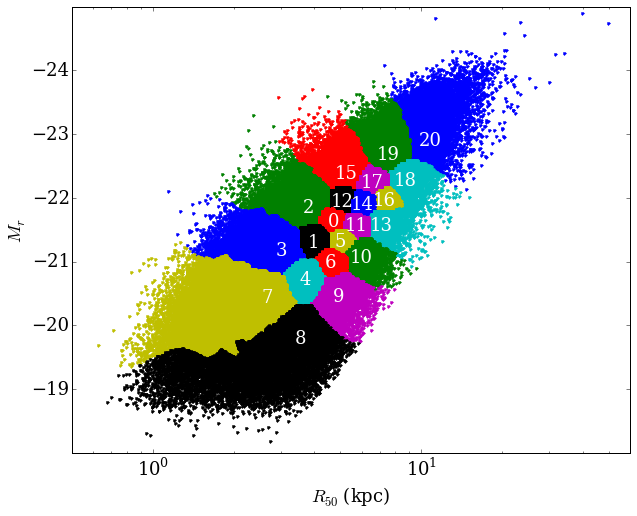

In [28]:
################ Voronoi bin plot ###################

bins,all_bins,debiased,fit_results,vbins_table,fit_setup = load_dataset(question,reference_answer)

vbins = all_bins['vbin']
Mr = full_data['PETROMAG_MR']
R50 = full_data['PETROR50_R_KPC']

relative_r = [((T-T.min())/(T.max()-T.min())) for T in [np.log10(vbins_table['R50']),vbins_table['Mr']]]
relative_r = relative_r[1]
r_sort = np.argsort(relative_r) # Trying to get neighbouring bins in different colours.

for v in np.unique(vbins)[r_sort]:
    inbin = vbins == v
    plt.plot(full_data['PETROR50_R_KPC'][inbin],full_data['PETROMAG_MR'][inbin], '.')
    
for v in range(len(vbins_table)):
    x_text_pos = 10**(vbins_table['R50'][v])
    y_text_pos = vbins_table['Mr'][v]
    plt.text(x_text_pos,y_text_pos,'{}'.format(v),
             color='w',horizontalalignment='center',
             verticalalignment='center')

    plt.ylabel(r"$M_r$")
    plt.xlabel(r"$R_{50}$ (kpc)")
    plt.xscale('log')
    _ = plt.axis((0.5, 60, -18, -25))

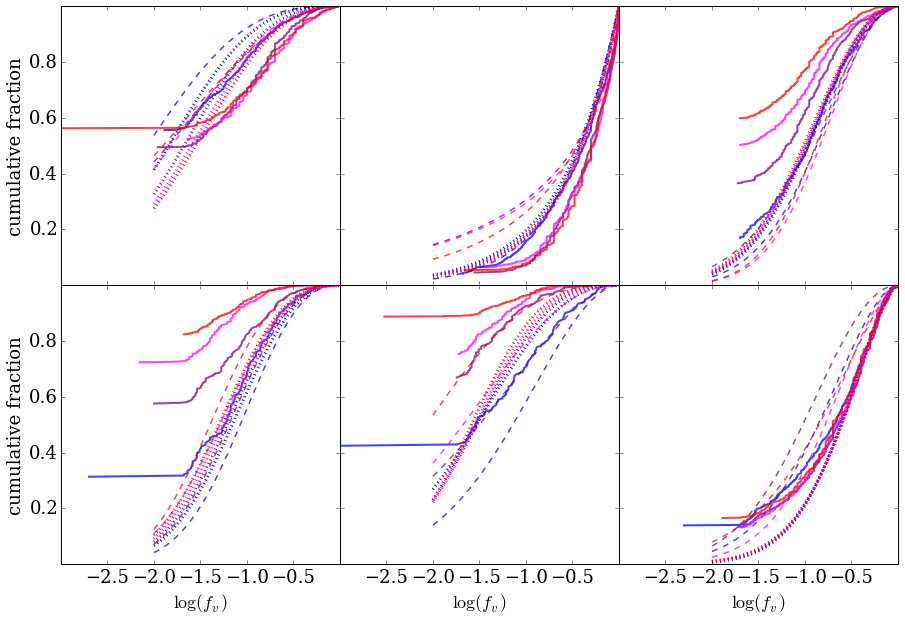

In [29]:
############### Example bin fitting plots ####################

v = 0

n_morph = len(answers)
fig,axarr = make_axes(n_morph,sharex=True,sharey=True)

clrs = ['blue','purple','magenta','red']
xg = np.linspace(-2,0,100)

for n,answer in enumerate(answers):
    
    bins,all_bins,debiased,fit_results,vbins_table,fit_setup = load_dataset(question,answer)
    
    #zbins = bins['coarse_zbin']
    zbins = bins['zbin']
    vbins = bins['vbin']
    func = fit_setup['func']
    
    vsel = vbins == v

    column = data[question + '_' + answer + '_weighted_fraction']
    zbins_v = zbins[vsel]

    for m,z in enumerate(np.unique(zbins_v)):
    
        zsel = zbins == z
        zv_column = column[(vsel) & (zsel)]
    
        cf = np.linspace(0,1,len(zv_column))
        fv = np.sort(zv_column)
        fv_nonzero = fv != 0
        log10fv = np.log10(fv[fv_nonzero])
        cf_plot = cf[fv_nonzero]
    
        fit = fit_results[(fit_results['vbin'] == v) & (fit_results['zbin'] == z)]
        k = fit['k']
        c = fit['c']
        kf = fit['kf']
        cf = fit['cf']
        
        axarr[n].plot(log10fv,cf_plot,color=clrs[m],linewidth=2,alpha=0.75)
        axarr[n].plot(xg,func(xg,k,c),color=clrs[m],linestyle='dashed',linewidth=1.5,alpha=0.75)
        axarr[n].plot(xg,func(xg,kf,cf),color=clrs[m],linestyle='dotted',linewidth=3)

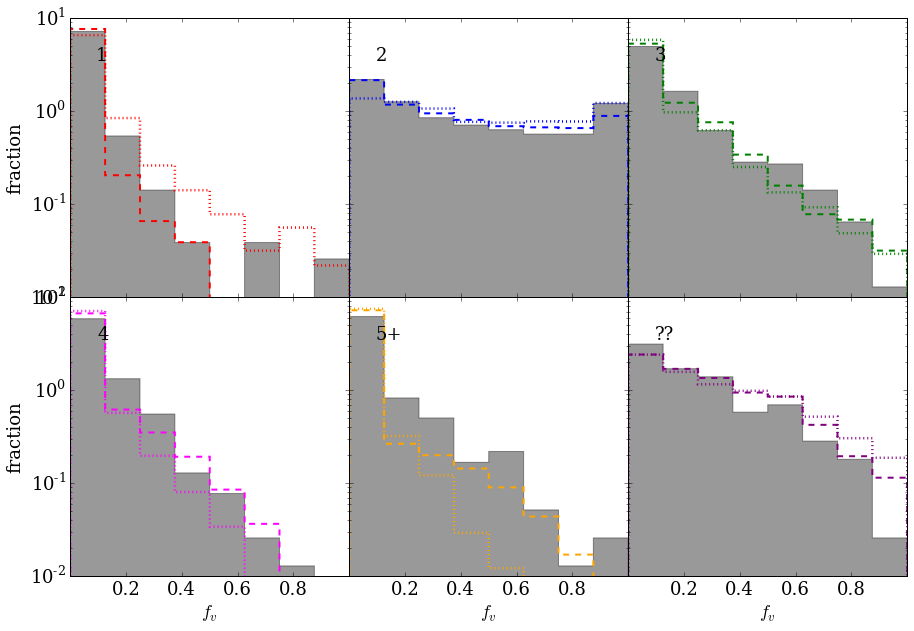

In [41]:
clrs = ['red','blue','green','magenta','orange','purple']

volume_ok = data['in_volume_limit'] == 1
low_z = (data['REDSHIFT_1'] >= 0.03) & (data['REDSHIFT_1'] < 0.035)
high_z = (data['REDSHIFT_1'] >= 0.08) & (data['REDSHIFT_1'] < 0.085)

fig,axarr = make_axes(n_morph,xlabel='$f_v$',ylabel='fraction')

for n,answer in enumerate(answers):
    
    bins,all_bins,debiased,fit_results,vbins_table,fit_setup = load_dataset(question,answer)

    reference_data = data[question + '_' + answer + '_weighted_fraction'][(volume_ok) & (low_z)]
    w13_data = data[question + '_' + answer + '_debiased'][(volume_ok) & (high_z)]
    h16_data = data[question + '_' + answer +'_debiased_rh'][(volume_ok) & (high_z)]
    
    h16_fit = debiased['fit_method'][select]
    h16_bin = debiased['bin_method'][select]
    
    h16_fit = h16_fit[(volume_ok) & (high_z)]
    h16_bin = h16_bin[(volume_ok) & (high_z)]

    bins = np.linspace(0,1,9)

    _ = axarr[n].hist(reference_data,bins=bins,histtype='stepfilled',color='k',alpha=0.4,normed=True)
    _ = axarr[n].hist(w13_data,bins=bins,histtype='step',color=clrs[n],linewidth=2.5,linestyle='dotted',normed=True)
    _ = axarr[n].hist(h16_fit,bins=bins,histtype='step',color=clrs[n],linewidth=2,linestyle='dashed',normed=True)
    #_ = axarr[n].hist(h16_bin,bins=bins,histtype='step',color=clrs[n],linewidth=2,linestyle='solid',normed=True)
    
    axarr[n].text(0.1,0.9,answerlabels[n],ha='left',va='top',transform=axarr[n].transAxes)
    
    axarr[n].set_yscale('log')
    
# dashed = fit method
# solid = bin method
# dotted = willett+ 2013
# grey = low reshift comparison

In [32]:
# k vs kfit, c vs cfit plots:

def plot_fits(a,ax,x='k',y='kf',question=question,questions=questions):
    
    label = questions[question]['answerlabels'][a]
    answer = questions[question]['answers'][a]
    
    plt.sca(ax)
    bins,all_bins,debiased,fit_results,vbins_table,fit_setup = load_dataset(question,answer)

    z = fit_results['redshift']

    plt.scatter(fit_results[x],fit_results[y],c=z,cmap=plt.cm.coolwarm,lw=0,s=50)

    # get axes:
    x_lower,x_upper = ax.get_xlim()
    y_lower,y_upper= ax.get_ylim()

    limits = [np.min([x_lower,y_lower]),np.min([x_upper,y_upper])]
    ax.set_xlim(limits)
    ax.set_ylim(limits)
    ax.plot(limits,limits,'k-')
    
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    
    cbar = plt.colorbar()
    
    ax.text(0.1,0.9,label,ha='left',va='top',transform=ax.transAxes)
    
    return None


def plot_kc_fit(a):
    fig,axarr = plt.subplots(1,2,figsize=(15,5))
    axarr = axarr.ravel()
    plot_fits(a,ax=axarr[0])
    plot_fits(a,ax=axarr[1],x='c',y='cf')
    return None

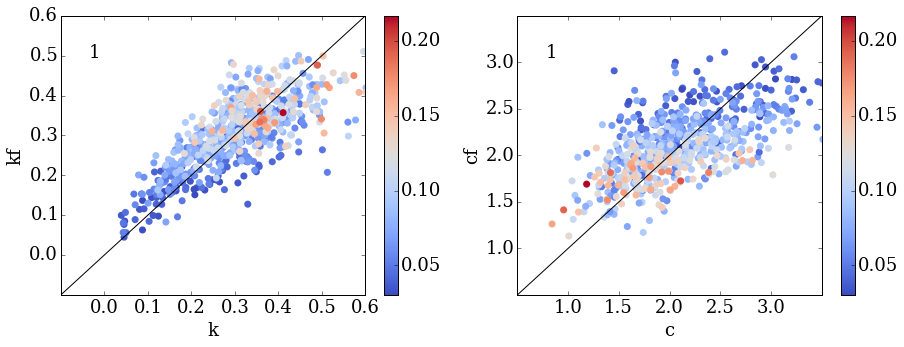

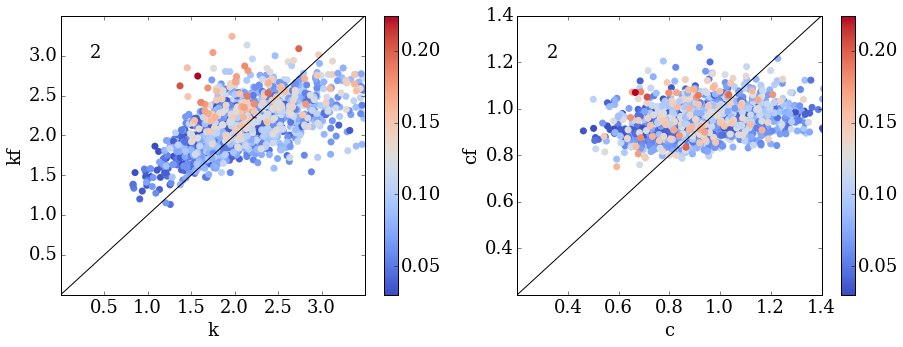

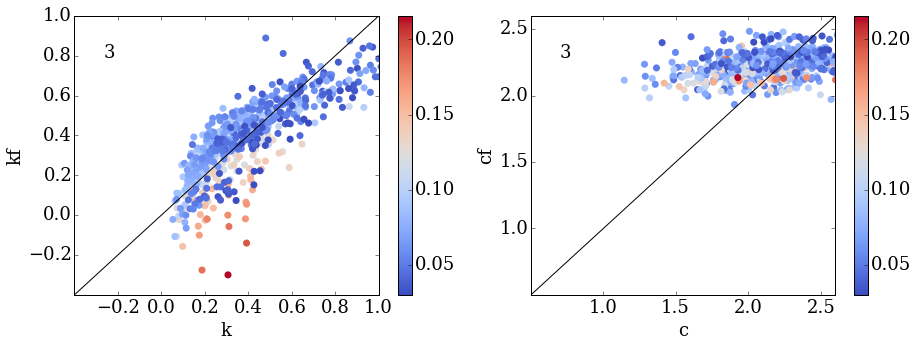

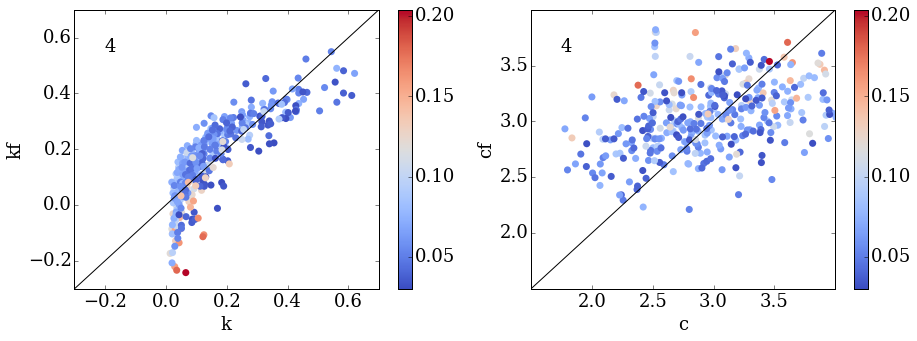

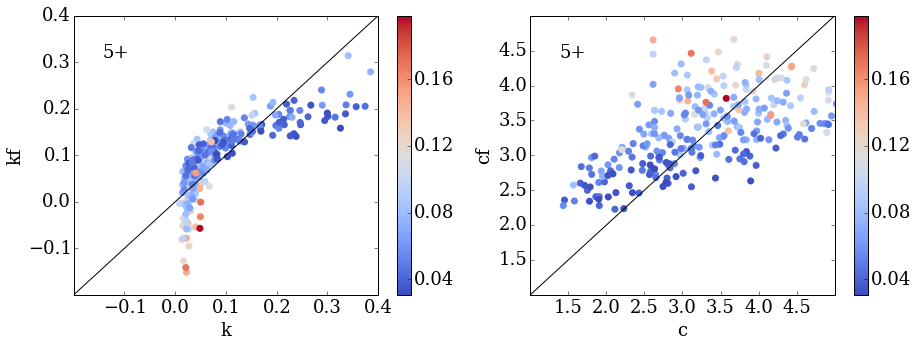

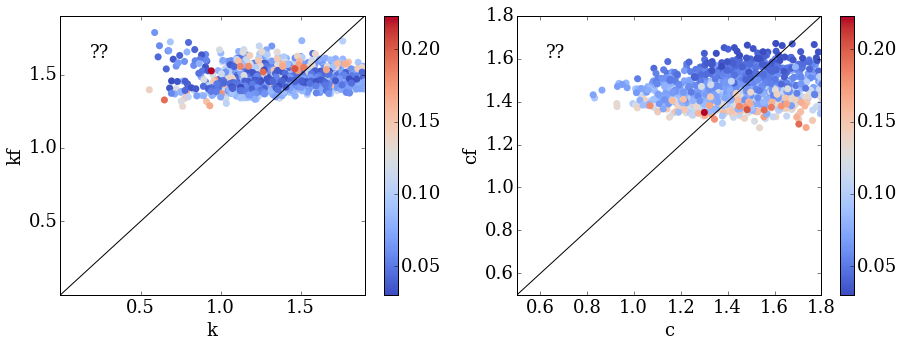

In [33]:
for a in range(len(questions[question]['answers'])):
    plot_kc_fit(a)

In [34]:
def raw_debiased_scatter(full_data,question=question,questions=questions,volume_limit=True,method='fit'):
    
    N = len(questions[question]['answers'])
    fig,axarr = make_axes(n_morph=N,xlabel='$f_v(raw)$'
                          ,ylabel='$f_v({{{}}})$'.format(method))
    labels = questions[question]['answerlabels']
    
    if volume_limit == True:
        vl_select = full_data['in_volume_limit'] == 1
    else:
        vl_select = np.ones(len(full_data))
        vl_select = vl_select == 1
    
    data,select = reduce_sample(full_data,questions,question)
    
    vl = full_data[(vl_select) & (select)]
    z = vl['REDSHIFT_1']
    
    for m,answer in enumerate(questions[question]['answers']):
        bins,all_bins,debiased,fit_results,vbins_table,fit_setup = load_dataset(question,answer)
        
        debiased_plot = debiased[method + '_method'][(vl_select) & (select)]
        raw_plot = vl[question + '_' + answer + '_weighted_fraction']
        
        plt.sca(axarr[m])
        plt.scatter(raw_plot,debiased_plot,c=z,cmap=plt.cm.coolwarm,lw=0,s=20)
        axarr[m].text(0.1,0.9,labels[m],ha='left',va='top',transform=axarr[m].transAxes)
        axarr[m].set_xlim(0,1)
        axarr[m].set_ylim(0,1)
        
    return None

54961/228201 galaxies with p>0.5 and N>=5.
54961/228201 galaxies with p>0.5 and N>=5.


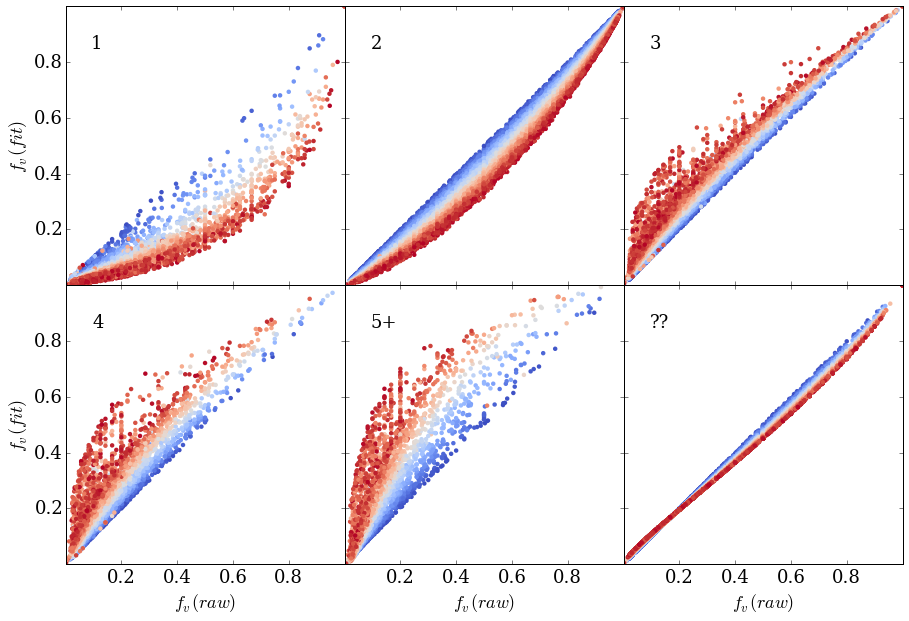

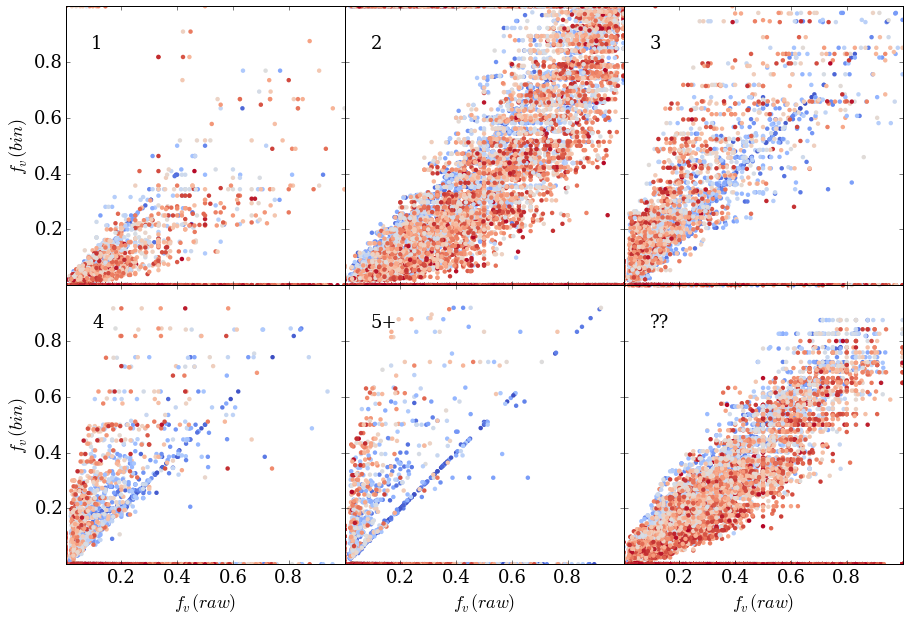

In [35]:
raw_debiased_scatter(full_data,method='fit',volume_limit=True)
raw_debiased_scatter(full_data,method='bin',volume_limit=True)

In [36]:
# Redshift trends:
from scipy.stats import binned_statistic

def bin_by_column(column, nbins, fixedcount=True):
    sorted_indices = np.argsort(column)
    if fixedcount:
        bin_edges = np.linspace(0, 1, nbins + 1)
        bin_edges[-1] += 1
        values = np.empty(len(column))
        values[sorted_indices] = np.linspace(0, 1, len(column))
        bins = np.digitize(values, bins=bin_edges)
    else:
        bin_edges = np.linspace(np.min(column),np.max(column), nbins + 1)
        bin_edges[-1] += 1
        values = column
        bins = np.digitize(values, bins=bin_edges)
    x, b, n = binned_statistic(values, column, bins=bin_edges)
    return x, bins

vl = data[volume_ok]

reference_data = vl[question + '_' + answer + '_weighted_fraction']
w13_data = vl[question + '_' + answer + '_debiased']
h16_data = vl[question + '_' + answer +'_debiased_rh']
redshifts = vl['REDSHIFT_1']

x,bins = bin_by_column(redshifts,nbins=20)